In [1]:
#from sSMC import MarginalDistr
import numpy as np
from numpy import dot

from scipy import linalg
from numpy import linalg as np_linalg
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import seaborn as sns

import os
import time

import pandas

from tqdm.notebook import tqdm

In [2]:
class MarginalDistr:

    def __init__(self, la1, la2, mu1, mu2):
        #mu1, mu2 - migration  rates
        #la1, la2 - coalescent rates
        #init_cond - vector of length 3
        self.la1 = la1
        self.la2 = la2
        
        self.mu1 = mu1
        self.mu2 = mu2

        #self.init_cond = np.array(init_cond)/sum(init_cond)

        self.SetMatrix(0.0)

    def m1(self, t):
        return self.mu1

    def m2(self, t):
        return self.mu2

    def l1(self, t):
        return self.la1

    def l2(self, t):
        return self.la2

    def SetMatrix(self, t):
        self.A = np.matrix( [[-2*self.m1(t)-self.l1(t), 0, self.m2(t)],
                             [0, -2*self.m2(t)-self.l2(t), self.m1(t)],
                             [2*self.m1(t), 2*self.m2(t), -self.m1(t) - self.m2(t)]] )

    def CalcProb(self, t, init_cond):
        MET = linalg.expm( dot(self.A, t) )
        return dot(MET, init_cond)

    def CalcDist(self, num_steps, step, init_cond):
        pr_dist = np.zeros(num_steps+1)
        MET = linalg.expm( dot(self.A, step) )
        for i in range(num_steps):
            pr_dist[i] = self.la1*init_cond[0]+self.la2*init_cond[1]
            init_cond = dot(MET, init_cond)
        pr_dist[num_steps] = self.la1*init_cond[0]+self.la2*init_cond[1]
        return pr_dist
    
class lineage:
    def __init__(self, a, b, p):
        #a and b indicates ancestral material (1) or non-ancestral (0)
        self.a = a
        self.b = b
        self.p = p#0 or 1 population

    def __str__(self):
        return str(self.a)+str(self.b)+str(self.p)

class state:
    def __init__(self, lng):
        self.lng = lng
        self.l = len(lng)
        self.name()
        self.stat()

    def name(self):
        lng_s = []
        for l in self.lng:
            lng_s.append( str(l.a) + str(l.b) + str(l.p) )
        lng_s.sort()
        self.n = ','.join(lng_s)
        
    def stat(self):
        self.num = {'a': 0, 'b': 0}
        self.index = {'a':[-1,-1],'b':[-1,-1]}
        ai, bi = 0, 0
        for i, l in enumerate(self.lng):
            if l.a == 1:
                self.num['a'] += 1
                self.index['a'][ai] = i
                ai += 1
            if l.b == 1:
                self.num['b'] += 1
                self.index['b'][bi] = i
                bi += 1
                
    def __str__(self):
        prstr = self.n + ": " + "num_a = " + str(self.num['a']) + ", " + "num_b = " + str(self.num['b']) + "\n    " + "index_a = " + str(self.index['a'][0:self.num['a']]) + "\n    " + "index_b = " + str(self.index['b'][0:self.num['b']])
        return(prstr)
    
#class scenario:
#    def __init__(self, name, params):
#        self.name = name
#        self.params = params
        
#scenario = "single_pop"
#def single_pop(rho, t):
#    return np.array([rho, 1.0, 1.0, 0.0, 0.0])

#single_pop = scenario("single_pop", single_pop)




In [120]:
numStates =[
    [ [1,1,0] ], # добавил два состояния
    [ [1,1,1] ],

    [ [1,1,0],[1,1,0] ],
    [ [1,1,0],[1,1,1] ],
    [ [1,1,1],[1,1,1] ],

    [ [1,0,0],[1,1,0] ],
    [ [1,0,0],[1,1,1] ],
    [ [1,0,1],[1,1,0] ],
    [ [1,0,1],[1,1,1] ],

    [ [0,1,0],[1,1,0] ],
    [ [0,1,0],[1,1,1] ],
    [ [0,1,1],[1,1,0] ],
    [ [0,1,1],[1,1,1] ],

    [ [0,1,0],[1,0,0] ],
    [ [0,1,0],[1,0,1] ],
    [ [0,1,1],[1,0,0] ],
    [ [0,1,1],[1,0,1] ],

    [ [1,0,0],[0,1,0],[1,1,0] ],
    [ [1,0,0],[0,1,0],[1,1,1] ],
    [ [1,0,0],[0,1,1],[1,1,0] ],
    [ [1,0,0],[0,1,1],[1,1,1] ],
    [ [1,0,1],[0,1,0],[1,1,0] ],
    [ [1,0,1],[0,1,0],[1,1,1] ],
    [ [1,0,1],[0,1,1],[1,1,0] ],
    [ [1,0,1],[0,1,1],[1,1,1] ],

    [ [1,0,0],[0,1,0],[0,1,0] ],
    [ [1,0,0],[0,1,0],[0,1,1] ],
    [ [1,0,0],[0,1,1],[0,1,1] ],
    [ [1,0,1],[0,1,0],[0,1,0] ],
    [ [1,0,1],[0,1,0],[0,1,1] ],
    [ [1,0,1],[0,1,1],[0,1,1] ],

    [ [1,0,0],[1,0,0],[0,1,0] ],
    [ [1,0,0],[1,0,0],[0,1,1] ],
    [ [1,0,0],[1,0,1],[0,1,0] ],
    [ [1,0,0],[1,0,1],[0,1,1] ],
    [ [1,0,1],[1,0,1],[0,1,0] ],
    [ [1,0,1],[1,0,1],[0,1,1] ],

    [ [1,0,0],[1,0,0],[0,1,0],[0,1,0] ],
    [ [1,0,0],[1,0,0],[0,1,0],[0,1,1] ],
    [ [1,0,0],[1,0,0],[0,1,1],[0,1,1] ],
    [ [1,0,0],[1,0,1],[0,1,0],[0,1,0] ],
    [ [1,0,0],[1,0,1],[0,1,0],[0,1,1] ],
    [ [1,0,0],[1,0,1],[0,1,1],[0,1,1] ],
    [ [1,0,1],[1,0,1],[0,1,0],[0,1,0] ],
    [ [1,0,1],[1,0,1],[0,1,0],[0,1,1] ],
    [ [1,0,1],[1,0,1],[0,1,1],[0,1,1] ]
]

Mdim = len(numStates)

states = []
stateToNum = {}
i = 0
for st in numStates:
    lng = []
    for l in st:
        lng.append( lineage(l[0], l[1], l[2]) )
    states.append( state(lng) )
    stateToNum[states[-1].n] = i
    i += 1

def Eq(P, t):
    return dot(dot(M,params(t)),P)

def Coal(st, i, k):
    if i > st.l or k > st.l:
        print("Wrong lineage index.")
    if st.lng[i].p != st.lng[k].p:
        print("Coalescence is impossible.")
    newState = [st.lng[j] for j in range(st.l) if i != j and k != j]
    newState.append(lineage(st.lng[i].a | st.lng[k].a, st.lng[i].b | st.lng[k].b, st.lng[i].p))
    newState = state(newState)
    if newState.l > 0: # добавил наличие поглощающего состояния длины 1
        return stateToNum[newState.n]
    else:
        return -1

#Matrix entry [rho, l1, l2, m1, m2] Thank's...

def Matrix():
    trRate = np.zeros( (Mdim, Mdim, 5), int ) # :,:,0 - recom., :,:,1-2 - coal., :,:,3-4 - migr. 
    for s in range(Mdim):
        st = states[s]
        for i in range(st.l):
            #recombination
            if st.lng[i].a & st.lng[i].b:
                newState = [st.lng[j] for j in range(st.l) if i != j]
                newState.append(lineage(1,0,st.lng[i].p))
                newState.append(lineage(0,1,st.lng[i].p))
                newState = state(newState)
                trRate[s, stateToNum[newState.n], 0] += 1
                trRate[s, s, 0] -= 1
            #coalescence
            for k in range(i+1,st.l):
                if st.lng[i].p == st.lng[k].p:
                    newState_id = Coal(st, i, k)
                    if newState_id != -1:
                        trRate[s, newState_id, st.lng[i].p+1 ] += 1
                    trRate[s, s, st.lng[i].p+1 ] -= 1
            #migration
            newState = [st.lng[j] for j in range(st.l) if i != j]
            newState.append( lineage(st.lng[i].a,st.lng[i].b,(st.lng[i].p+1)%2) )
            newState = state(newState)
            trRate[s, stateToNum[newState.n], st.lng[i].p+3 ] += 1
            trRate[s, s, st.lng[i].p+3 ] -= 1
    return( np.transpose(trRate, (1,0,2)) )

def FirstCoal(locus, t, params, popID = -1):
    matr = np.zeros( (Mdim, Mdim) )
    for s, st in enumerate(states):
        if not (st.num['a'] == 2 and st.num['b'] == 2 and st.l > 2):
            continue
        lng_i0, lng_i1 = st.index[locus][0], st.index[locus][1]
        if not (popID == -1 and st.lng[lng_i0].p == st.lng[lng_i1].p) and not (popID != -1 and st.lng[lng_i0].p == popID and st.lng[lng_i1].p == popID):
            continue
        newState_id = Coal(st, lng_i0, lng_i1)
        matr[ newState_id, s ] += params(t)[ st.lng[lng_i0].p + 1 ]
    return matr

def SecondCoal(locus, t, params, popID = -1):
    matr = np.zeros( (Mdim, Mdim) )
    
    locus2 = 'b'
    if locus == 'b':
        locus2 = 'a'
        
    for s, st in enumerate(states):
        if not (st.num[locus] == 2 and st.num[locus2] == 1):
            continue
        lng_i0, lng_i1 = st.index[locus][0], st.index[locus][1]
        if not (popID == -1 and st.lng[lng_i0].p == st.lng[lng_i1].p) and not (popID != -1 and st.lng[lng_i0].p == popID and st.lng[lng_i1].p == popID):
            continue
        newState_id = Coal(st, lng_i0, lng_i1)
        #print(st.n, states[newState_id].n)
        matr[ newState_id, s ] += params(t)[ st.lng[lng_i0].p + 1 ]
    return matr

def DoubleCoal(t, params, pop_a = -1, pop_b = -1): # полностью новая функция
    matrd = np.zeros( (Mdim, Mdim) )
    matrd2 = np.zeros( (Mdim, Mdim) )
    for s, st in enumerate(states):
        if (pop_a == pop_b and st.num['a'] == 2 and st.num['b'] == 2 and st.l == 2):
            lng_i0, lng_i1 = st.index['a'][0], st.index['a'][1]
            if (pop_a == -1 and st.lng[lng_i0].p == st.lng[lng_i1].p) \
            or (pop_a != -1 and st.lng[lng_i0].p == pop_a and st.lng[lng_i1].p == pop_a):
                newState_id = Coal(st, lng_i0, lng_i1)
                matrd[ newState_id, s ] += params(t)[ st.lng[lng_i0].p + 1 ]
        elif (st.num['a'] == 2 and st.num['b'] == 2 and st.l > 2):
            lng_i0, lng_i1, lng_i2, lng_i3 = st.index['a'][0], st.index['a'][1], st.index['b'][0], st.index['b'][1]
            pa0, pa1, pb0, pb1 = st.lng[lng_i0].p, st.lng[lng_i1].p, st.lng[lng_i2].p, st.lng[lng_i3].p
            if pop_a == -1 or (pop_a == pa0 and pop_b == pb0):
                if st.l == 3 and (pa0 + pa1 + pb0 + pb1) % 4 == 0:
                    newState_id = stateToNum[f'11{pa0}']
                    matrd2[ newState_id, s ] += params(t)[ pa0 + 1 ]**2
                elif st.l == 4 and pa0 == pa1 and pb0 == pb1:
                    newState_id = stateToNum[state([lineage(0, 1, pa0), lineage(1, 0, pb0)]).n]
                    matrd2[ newState_id, s ] += params(t)[ pa0 + 1 ] * params(t)[ pb0 + 1 ]
    return matrd, matrd2

def filename(scenario, dim, dt, rho):
    fn = "data_" + str(dim) + "_" + str(dt) + "_" + str(rho) + ".npy"
    fn = "data/" + scenario + "/" + fn
    return(fn)


def Eq(P, t, params):
    return dot(dot(M,params(t)),P)

def solve_eq(params, times, Pinit):
    sol = odeint(lambda P, t: Eq(P, t, params), Pinit, times)
    return(sol[1,])

def solve_eq2(params, times, Pinit):
    sol = odeint(lambda P, t: Eq(P, t, params), Pinit, times)
    return(sol)

def densityTaTb(method, params, Ta, Tb, h, pop_a = -1, pop_b = -1):
    if method == 'ode':
        return densityTaTb_ode(params, Ta, Tb, pop_a=pop_a, pop_b=pop_b)
    else:
        return densityTaTb_expm(params, Ta, Tb, h, pop_a=pop_a, pop_b=pop_b)

def densityTaTb_ode(params, Ta, Tb, pop_a = -1, pop_b = -1):
    if Ta < Tb:
        P = solve_eq(params, [0., Ta], Pinit)
        P = dot(FirstCoal('a', Ta, params, pop_a), P)

        P = solve_eq(params, [Ta, Tb], P)
        P = dot(SecondCoal('b', Tb, params, pop_b), P)
    elif Ta > Tb:
        P = solve_eq(params, [0., Tb], Pinit)
        P = dot(FirstCoal('b', Tb, params, pop_b), P)

        P = solve_eq(params, [Tb, Ta], P)
        P = dot(SecondCoal('a', Ta, params, pop_a), P)
    else:
        P = solve_eq(params, [0, Ta], Pinit)
        P = dot(DoubleCoal(Ta, params, pop_a, pop_b), P)
    return( sum(P) )

# вставил домножение на шаг по времени внутрь функции, изменил саму фкнцию немного
def densityTaTb_expm(params, Ta, Tb, h, pop_a = -1, pop_b = -1):
    if Ta < Tb:
        Mexp = linalg.expm( dot(M, params(0))*Ta ) # (M, params) = good transition matrix, MAGIC!!!!!
        P = dot(Mexp, Pinit)
        # print(P)
        P = dot(FirstCoal('a', Ta, params, pop_a), P)
        Mexp = linalg.expm( dot(M, params(0))*(Tb-Ta) )
        P = dot(Mexp, P)
        P = dot(SecondCoal('b', Tb, params, pop_b), P) *h
    elif Ta > Tb:
        Mexp = linalg.expm( dot(M, params(0))*Tb )
        P = dot(Mexp, Pinit)
        P = dot(FirstCoal('b', Tb, params, pop_b), P)
        Mexp = linalg.expm( dot(M, params(0))*(Ta-Tb) )
        P = dot(Mexp, P)
        P = dot(SecondCoal('a', Ta, params, pop_a), P) *h
    else:
        Mexp = linalg.expm( dot(M, params(0))*Ta )
        P = dot(Mexp, Pinit)
        matrd, matrd2 = DoubleCoal(Ta, params, pop_a, pop_b)
        P = dot(matrd, P) + dot(matrd2, P) * h
    return P.sum()

In [121]:
# Проверка
m = DoubleCoal(0, params, pop_a=-1, pop_b=-1)[1] # [0] - first order, [1] - second order
for numst in numStates:
    lng = []
    for numlng in numst:
        lng.append( lineage(*numlng) )
    st = state(lng)
    i = stateToNum[st.n]
    print(st.n, np.array(numStates)[m[i] != 0])

110 [list([[1, 0, 0], [0, 1, 0], [1, 1, 0]])]
111 [list([[1, 0, 1], [0, 1, 1], [1, 1, 1]])]
110,110 []
110,111 []
111,111 []
100,110 []
100,111 []
101,110 []
101,111 []
010,110 []
010,111 []
011,110 []
011,111 []
010,100 [list([[1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0]])]
010,101 [list([[1, 0, 0], [1, 0, 0], [0, 1, 1], [0, 1, 1]])]
011,100 [list([[1, 0, 1], [1, 0, 1], [0, 1, 0], [0, 1, 0]])]
011,101 [list([[1, 0, 1], [1, 0, 1], [0, 1, 1], [0, 1, 1]])]
010,100,110 []
010,100,111 []
011,100,110 []
011,100,111 []
010,101,110 []
010,101,111 []
011,101,110 []
011,101,111 []
010,010,100 []
010,011,100 []
011,011,100 []
010,010,101 []
010,011,101 []
011,011,101 []
010,100,100 []
011,100,100 []
010,100,101 []
011,100,101 []
010,101,101 []
011,101,101 []
010,010,100,100 []
010,011,100,100 []
011,011,100,100 []
010,010,100,101 []
010,011,100,101 []
011,011,100,101 []
010,010,101,101 []
010,011,101,101 []
011,011,101,101 []


/var/folders/4w/w469rcgn2y3dk9h8brh57df40000gn/T/ipykernel_8721/1053482811.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(st.n, np.array(numStates)[m[i] != 0])


In [122]:
M = Matrix()

# явно задаю начальное состояние
Pinit = np.zeros(Mdim) 
initial_state = state([lineage(1, 1, 0), lineage(1, 1, 0)])
Pinit[stateToNum[initial_state.n]] = 1.0

# рефернсные параметры из файлы sSMC.ipynb
def params(rho, t):
    return np.array([rho, 1.0, 1.0, 0.1, 0.1])

method = 'expm'

In [183]:
dim = 80
dt = 20

rho_dx = 0.001
rho_m = 1.

data_dx = np.zeros((4, dim, dim), float)
c = 0
for pop_a in [0, 1]:
    for pop_b in [0, 1]:
        for i in tqdm(range(dim)):
            for j in range(dim):
                data_dx[c, i, j] = densityTaTb(method, lambda t: params(rho_dx, t), 
                                         i/dt, j/dt, 1/dt, pop_a=pop_a, pop_b=pop_b)
        c += 1


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

TypeError: _block_dispatcher() takes 1 positional argument but 4 were given

In [197]:
data_dx = np.block([[data_dx[0], data_dx[1]], [data_dx[2], data_dx[3]]])

In [198]:
data_dx.shape

(160, 160)

In [199]:
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / np.where(row_sums[:, np.newaxis]>0, row_sums[:, np.newaxis], np.ones(dim*2))

marg_diagonal = np.zeros( (dim*2, dim*2) )
for i in range(dim*2):
    marg_diagonal[i,i] = row_sums[i]# margdist[i]
    
vals = [i/10. for i in range(1,1)]

TV_single_pop = []
for rho_m in vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)

    data = [[densityTaTb(method, lambda t: params(rho_m, t), i/dt, j/dt)/dt if i != j else densityTaTb(method, lambda t: params(rho_m, t), i/dt, j/dt) for j in range(dim)] for i in range(dim) ]
    data = np.array(data)
    
    TV_single_pop.append( np.sum(abs(joint_smc-data))/dt*0.5 )

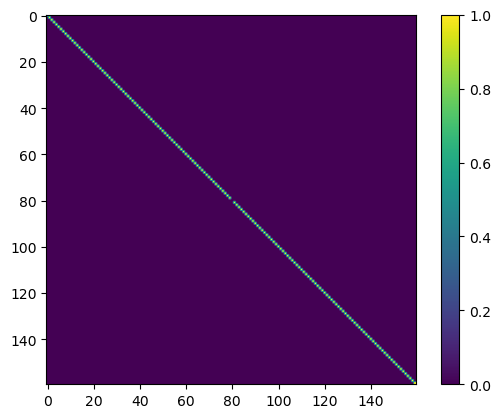

In [201]:
plt.imshow(trans_matrix_smc)
plt.colorbar()

In [155]:
densityTaTb(method, lambda t: params(0.001, t), 0, 0, 1, pop_a=1, pop_b=1)

0.0

<AxesSubplot:>

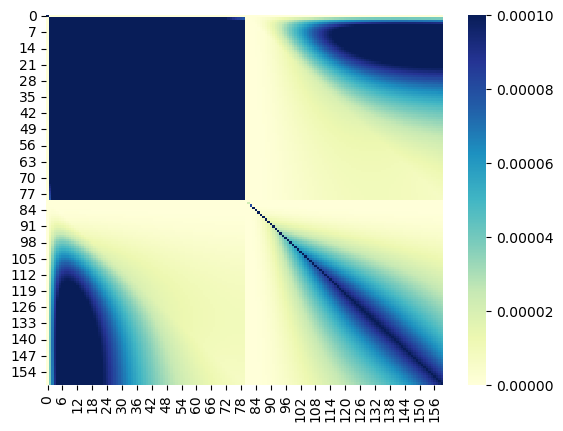

In [205]:
joint_smc = np_linalg.matrix_power(trans_matrix_smc, 1000)
joint_smc = np.matmul(marg_diagonal, joint_smc)

sns.heatmap(joint_smc, cmap="YlGnBu", vmax=0.0001)

<AxesSubplot:>

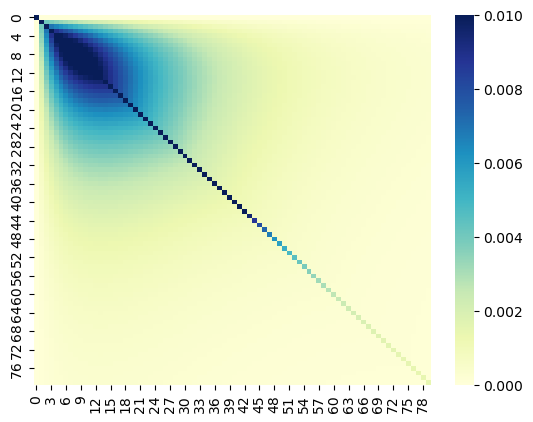

In [207]:
sns.heatmap(joint_smc[:80, :80], cmap="YlGnBu", vmax=0.01)

<AxesSubplot:>

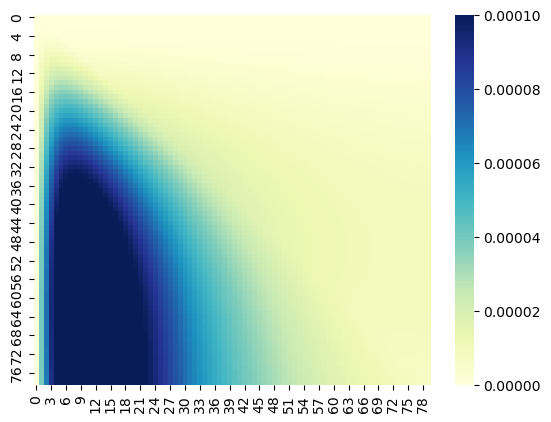

In [210]:
sns.heatmap(joint_smc[81:160, :80], cmap="YlGnBu", vmax=0.0001)

<AxesSubplot:>

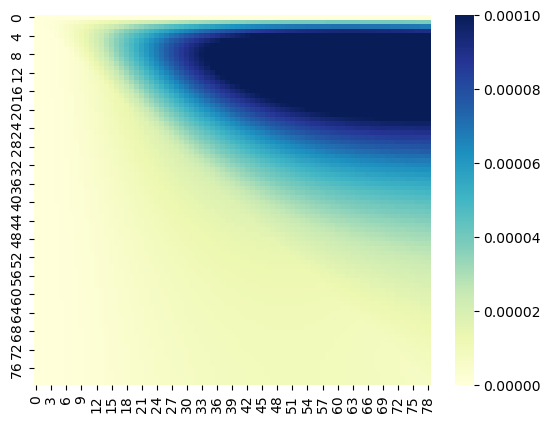

In [211]:
sns.heatmap(joint_smc[:80, 81:160], cmap="YlGnBu", vmax=0.0001)

<AxesSubplot:>

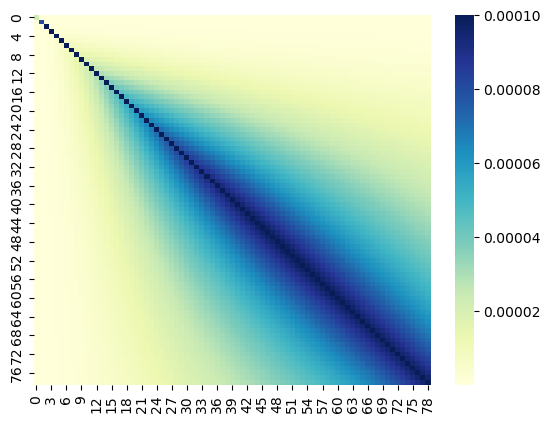

In [212]:
sns.heatmap(joint_smc[81:160, 81:160], cmap="YlGnBu", vmax=0.0001)

## Дальше ниче не менял

In [55]:
Mexp = linalg.expm( dot(M, params(0))*Ta )
        P = dot(Mexp, Pinit)

IndentationError: unexpected indent (754893848.py, line 2)

In [61]:
dim = 200
dt = 50

rho_dx = 0.001
rho_m = 1.

offset = 0.0

method = 'expm'

def params(rho, t):
    return np.array([rho, 1.0, 1.0, 0.1, 0.1])

data_dx = np.zeros((dim, dim), float)

for i in range(dim):
    for j in range(dim):
        if i != j:
            data_dx[i, j] = densityTaTb(method, lambda t: params(rho_dx, t), (i+offset)/dt, (j+offset)/dt)/dt
        else:
            data_dx[i, j] = densityTaTb(method, lambda t: params(rho_dx, t), (i+offset)/dt, (j+offset)/dt)
            

data_dx = [[ if i != j else  for j in range(dim)] for i in range(dim) ]
data_dx = np.array(data_dx)
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = row_sums[i]# margdist[i]
    
vals = [i/10. for i in range(1,101)]

TV_eq_size = []
for rho_m in tqdm(vals):
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)

    data = [[densityTaTb(method, lambda t: params(rho_m, t), i/dt, j/dt)/dt if i != j else densityTaTb(method, lambda t: params(rho_m, t), i/dt, j/dt) for j in range(dim)] for i in range(dim) ]
    data = np.array(data)
    
    TV_eq_size.append( np.sum(abs(joint_smc-data))/dt*0.5 )

KeyboardInterrupt: 

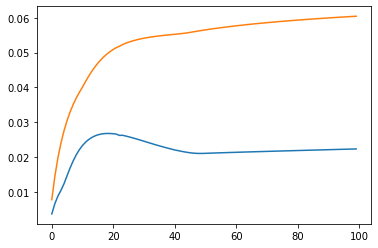

In [6]:
plt.plot(TV_single_pop)
plt.plot(TV_eq_size)

In [7]:
TV_single_pop[14:20]

[0.02603211515054129,
 0.026358263590117066,
 0.026569983375623534,
 0.02669607356810815,
 0.026752478365920873,
 0.026739709015222952]

In [125]:
dim = 80
dt = 20

rho_dx = 1.
rho_m = 100.

offset = 0.0

method = 'expm'

def params(rho, t):
    return np.array([rho, 1.0, 1.0, 0.0, 0.0])

data_dx = [[densityTaTb(method, lambda t: params(rho_dx, t), (i+offset)/dt, (j+offset)/dt)/dt if i != j else densityTaTb(method, lambda t: params(rho_dx, t), (i+offset)/dt, (j+offset)/dt) for j in range(dim)] for i in range(dim) ]
#data_dx = [[densityTaTb(method, lambda t: params(rho_dx, t), i/dt, j/dt)/dt if i != j else densityTaTb(method, lambda t: params(rho_dx, t), i/dt, j/dt) for j in range(dim)] for i in range(dim) ]
data_dx = np.array(data_dx)
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = row_sums[i]# margdist[i]

joint_smc = marg_diagonal
for i in range( int(rho_m/rho_dx) ):
    joint_smc = np.matmul(joint_smc, trans_matrix_smc)
    
if True:
    data = [[densityTaTb(method, lambda t: params(rho_m, t), (i+offset)/dt, (j+offset)/dt)/dt if i != j else densityTaTb(method, lambda t: params(rho_m, t), (i+offset)/dt, (j+offset)/dt) for j in range(dim)] for i in range(dim) ]
    #data = [[densityTaTb(method, lambda t: params(rho_m, t), i/dt, j/dt)/dt if i != j else densityTaTb(method, lambda t: params(rho_m, t), i/dt, j/dt) for j in range(dim)] for i in range(dim) ]
    data = np.array(data)

    np.sum(abs(joint_smc-data))/dt*0.5
#

In [109]:
joint_smc/np.sum(joint_smc)

array([[3.18167287e-03, 3.42868341e-04, 3.36079671e-04, ...,
        6.79637334e-06, 6.66166869e-06, 6.52963137e-06],
       [3.42868341e-04, 4.50070001e-04, 3.83161102e-04, ...,
        7.74844372e-06, 7.59486883e-06, 7.44433493e-06],
       [3.36079671e-04, 3.83161102e-04, 3.78050484e-04, ...,
        7.61813438e-06, 7.46714223e-06, 7.31913992e-06],
       ...,
       [6.79637334e-06, 7.74844372e-06, 7.61813438e-06, ...,
        1.54068259e-07, 1.51014611e-07, 1.48021430e-07],
       [6.66166869e-06, 7.59486883e-06, 7.46714223e-06, ...,
        1.51014611e-07, 1.48021487e-07, 1.45087631e-07],
       [6.52963137e-06, 7.44433493e-06, 7.31913992e-06, ...,
        1.48021430e-07, 1.45087631e-07, 1.42211925e-07]])

In [108]:
data/np.sum(data)

array([[2.84375777e-03, 3.48061089e-04, 3.41169018e-04, ...,
        6.90591305e-06, 6.76916681e-06, 6.63512832e-06],
       [3.48061089e-04, 6.85140591e-05, 3.86906163e-04, ...,
        7.83172029e-06, 7.67664183e-06, 7.52463414e-06],
       [3.41169018e-04, 3.86906163e-04, 6.72147997e-06, ...,
        7.70074850e-06, 7.54826346e-06, 7.39879783e-06],
       ...,
       [6.90591305e-06, 7.83172029e-06, 7.70074850e-06, ...,
        1.50780504e-09, 1.52931155e-07, 1.49902915e-07],
       [6.76916681e-06, 7.67664183e-06, 7.54826346e-06, ...,
        1.52931155e-07, 1.44868876e-09, 1.46935207e-07],
       [6.63512832e-06, 7.52463414e-06, 7.39879783e-06, ...,
        1.49902915e-07, 1.46935207e-07, 1.39189024e-09]])

In [106]:
marg_dist = row_sums/sum(row_sums)
joint_infty = np.reshape(marg_dist, (dim, 1) ) @ np.reshape(marg_dist, (1, dim) )
joint_infty

array([[4.06923016e-04, 3.98864801e-04, 3.90966173e-04, ...,
        7.90627822e-06, 7.74957503e-06, 7.59597478e-06],
       [3.98864801e-04, 3.90966161e-04, 3.83223948e-04, ...,
        7.74971178e-06, 7.59611175e-06, 7.44555321e-06],
       [3.90966173e-04, 3.83223948e-04, 3.75635052e-04, ...,
        7.59624602e-06, 7.44568770e-06, 7.29811063e-06],
       ...,
       [7.90627822e-06, 7.74971178e-06, 7.59624602e-06, ...,
        1.53614401e-07, 1.50569749e-07, 1.47585385e-07],
       [7.74957503e-06, 7.59611175e-06, 7.44568770e-06, ...,
        1.50569749e-07, 1.47585442e-07, 1.44660229e-07],
       [7.59597478e-06, 7.44555321e-06, 7.29811063e-06, ...,
        1.47585385e-07, 1.44660229e-07, 1.41792994e-07]])

In [107]:
np.sum(data)

47.7931381929634

In [98]:
np.sum(joint_infty)

1.0000000000000007

In [96]:
vec = trans_matrix_smc @ np.reshape(marg_dist, (dim, 1) ) - np.reshape(marg_dist, (dim, 1) )
sum( abs(vec) )

array([0.00503328])

In [69]:
np.sum(trans_matrix_smc)

200.0

In [81]:
data-joint_infty

array([[7.66168190e-03, 4.49861264e-02, 4.27921276e-02, ...,
        2.49455841e-06, 2.37289763e-06, 2.25717031e-06],
       [4.49861264e-02, 6.75665390e-05, 4.10339630e-02, ...,
        2.39206652e-06, 2.27540431e-06, 2.16443179e-06],
       [4.27921276e-02, 4.10339630e-02, 5.39236809e-05, ...,
        2.27544736e-06, 2.16447272e-06, 2.05891038e-06],
       ...,
       [2.49455841e-06, 2.39206652e-06, 2.27544736e-06, ...,
        1.84681135e-13, 1.26416056e-10, 1.20250686e-10],
       [2.37289763e-06, 2.27540431e-06, 2.16447272e-06, ...,
        1.26416056e-10, 1.67137681e-13, 1.14387112e-10],
       [2.25717031e-06, 2.16443179e-06, 2.05891038e-06, ...,
        1.20250686e-10, 1.14387112e-10, 1.51261971e-13]])

In [101]:
vec = np.reshape(marg_dist, (dim, 1) )
for i in range(1):
    vec = trans_matrix_smc @ vec
vec-np.reshape(marg_dist, (dim, 1) )

array([[-1.18877072e-06],
       [-3.22363950e-06],
       [-4.85096566e-06],
       [-6.12335103e-06],
       [-7.08677051e-06],
       [-7.78143716e-06],
       [-8.24255070e-06],
       [-8.50094540e-06],
       [-8.58365123e-06],
       [-8.51438003e-06],
       [-8.31394712e-06],
       [-8.00063700e-06],
       [-7.59052077e-06],
       [-7.09773199e-06],
       [-6.53470632e-06],
       [-5.91239016e-06],
       [-5.24042219e-06],
       [-4.52729157e-06],
       [-3.78047602e-06],
       [-3.00656222e-06],
       [-2.21135113e-06],
       [-1.39995006e-06],
       [-5.76853326e-07],
       [ 2.53987083e-07],
       [ 1.08909943e-06],
       [ 1.92543772e-06],
       [ 2.76033376e-06],
       [ 3.59145487e-06],
       [ 4.41676663e-06],
       [ 5.23449997e-06],
       [ 6.04312207e-06],
       [ 6.84131055e-06],
       [ 7.62793067e-06],
       [ 8.40201497e-06],
       [ 9.16274527e-06],
       [ 9.90943658e-06],
       [ 1.06415228e-05],
       [ 1.13585438e-05],
       [ 1.2

In [102]:
np.sum( abs (vec-np.reshape(marg_dist, (dim, 1) )) )

0.0050332844336871295

In [120]:
np.sum(data/np.sum(data),axis=1)-marg_dist/sum(marg_dist)

ValueError: operands could not be broadcast together with shapes (80,) (200,) 

In [121]:
data_dx.sum(axis=1)/data_dx.sum()-data.sum(axis=1)/data.sum()

array([ 2.64331523e-03,  2.14729882e-03,  1.70921596e-03,  1.34758308e-03,
        1.04878505e-03,  8.01762868e-04,  5.97518076e-04,  4.28699801e-04,
        2.89281426e-04,  1.74305866e-04,  7.96836670e-05,  2.03207183e-06,
       -6.14539353e-05, -1.13105468e-04, -1.54863722e-04, -1.88348171e-04,
       -2.14912162e-04, -2.35688373e-04, -2.51626119e-04, -2.63522029e-04,
       -2.72045363e-04, -2.77758934e-04, -2.81136453e-04, -2.82576926e-04,
       -2.82416638e-04, -2.80939134e-04, -2.78383564e-04, -2.74951649e-04,
       -2.70813527e-04, -2.66112655e-04, -2.60969922e-04, -2.55487118e-04,
       -2.49749854e-04, -2.43830021e-04, -2.37787873e-04, -2.31673789e-04,
       -2.25529759e-04, -2.19390652e-04, -2.13285286e-04, -2.07237342e-04,
       -2.01266135e-04, -1.95387276e-04, -1.89613236e-04, -1.83953821e-04,
       -1.78416586e-04, -1.73007178e-04, -1.67729639e-04, -1.62586660e-04,
       -1.57579795e-04, -1.52709650e-04, -1.47976043e-04, -1.43378137e-04,
       -1.38914556e-04, -

In [ ]:
densityTaTb('ode', lambda t: params(rho_dx, t), 1., 1.)-densityTaTb('expm', lambda t: params(rho_dx, t), 1., 1.)

In [119]:
md = MarginalDistr(params(rho_dx, 0)[1], params(rho_dx, 0)[2], params(rho_dx, 0)[3], params(rho_dx, 0)[4])
md.CalcDist(dim, 1./dt, [1., 0., 0.])

array([1.        , 0.95122942, 0.90483742, 0.86070798, 0.81873075,
       0.77880078, 0.74081822, 0.70468809, 0.67032005, 0.63762815,
       0.60653066, 0.57694981, 0.54881164, 0.52204578, 0.4965853 ,
       0.47236655, 0.44932896, 0.42741493, 0.40656966, 0.38674102,
       0.36787944, 0.34993775, 0.33287108, 0.31663677, 0.30119421,
       0.2865048 , 0.27253179, 0.25924026, 0.24659696, 0.23457029,
       0.22313016, 0.21224797, 0.20189652, 0.19204991, 0.18268352,
       0.17377394, 0.16529889, 0.15723717, 0.14956862, 0.14227407,
       0.13533528, 0.1287349 , 0.12245643, 0.11648416, 0.11080316,
       0.10539922, 0.10025884, 0.09536916, 0.09071795, 0.08629359,
       0.082085  , 0.07808167, 0.07427358, 0.07065121, 0.06720551,
       0.06392786, 0.06081006, 0.05784432, 0.05502322, 0.05233971,
       0.04978707, 0.04735892, 0.0450492 , 0.04285213, 0.0407622 ,
       0.03877421, 0.03688317, 0.03508435, 0.03337327, 0.03174564,
       0.03019738, 0.02872464, 0.02732372, 0.02599113, 0.02472

In [128]:
data_dx.sum(axis=1)

array([1.        , 0.94516519, 0.89420953, 0.84670079, 0.80227877,
       0.76064048, 0.72152866, 0.68472299, 0.6500331 , 0.61729321,
       0.5863578 , 0.55709818, 0.52939976, 0.50315985, 0.47828582,
       0.45469368, 0.43230686, 0.41105521, 0.3908742 , 0.37170423,
       0.35349004, 0.33618024, 0.31972691, 0.30408522, 0.28921319,
       0.27507136, 0.26162263, 0.24883204, 0.2366666 , 0.22509514,
       0.2140882 , 0.20361788, 0.19365775, 0.18418276, 0.17516915,
       0.16659438, 0.15843702, 0.15067676, 0.14329426, 0.13627116,
       0.12959001, 0.1232342 , 0.11718797, 0.11143628, 0.10596486,
       0.10076012, 0.09580913, 0.0910996 , 0.08661981, 0.08235863,
       0.07830546, 0.07445021, 0.07078328, 0.06729553, 0.06397826,
       0.06082321, 0.05782249, 0.0549686 , 0.05225441, 0.04967313,
       0.04721829, 0.04488376, 0.04266366, 0.04055244, 0.03854479,
       0.03663567, 0.03482027, 0.03309403, 0.0314526 , 0.02989184,
       0.02840782, 0.0269968 , 0.0256552 , 0.02437963, 0.02316

In [129]:
data.sum(axis=1)

array([1.        , 0.86894805, 0.8286655 , 0.79015887, 0.75334872,
       0.71816955, 0.68455744, 0.65245011, 0.62178698, 0.59250918,
       0.56455964, 0.53788305, 0.51242591, 0.48813651, 0.46496493,
       0.442863  , 0.42178431, 0.40168415, 0.38251952, 0.36424904,
       0.34683297, 0.33023312, 0.31441284, 0.29933696, 0.28497177,
       0.27128495, 0.25824552, 0.24582382, 0.23399147, 0.22272128,
       0.21198726, 0.20176455, 0.19202935, 0.18275896, 0.17393165,
       0.16552667, 0.15752421, 0.14990533, 0.14265197, 0.13574688,
       0.1291736 , 0.1229164 , 0.11696031, 0.11129103, 0.10589492,
       0.10075897, 0.09587078, 0.09121852, 0.08679093, 0.08257726,
       0.07856727, 0.07475119, 0.07111973, 0.06766403, 0.06437565,
       0.06124653, 0.05826902, 0.05543582, 0.05273997, 0.05017486,
       0.04773419, 0.04541193, 0.04320239, 0.04110011, 0.03909991,
       0.03719685, 0.03538624, 0.0336636 , 0.03202467, 0.0304654 ,
       0.02898193, 0.02757058, 0.02622787, 0.02495046, 0.02373

In [137]:
def params(rho, t):
    return np.array([rho, 10., 1.0, 0.1, 0.01])

for i in range( len(states) ):
    for j in range( len(states) ):
        print(states[i].n, states[j].n, M[j, i], dot(M, params(100., 0))[j,i])
    print("\n")

110,110 110,110 [-2 -1  0 -2  0] -210.2
110,110 110,111 [0 0 0 2 0] 0.2
110,110 111,111 [0 0 0 0 0] 0.0
110,110 100,110 [0 0 0 0 0] 0.0
110,110 100,111 [0 0 0 0 0] 0.0
110,110 101,110 [0 0 0 0 0] 0.0
110,110 101,111 [0 0 0 0 0] 0.0
110,110 010,110 [0 0 0 0 0] 0.0
110,110 010,111 [0 0 0 0 0] 0.0
110,110 011,110 [0 0 0 0 0] 0.0
110,110 011,111 [0 0 0 0 0] 0.0
110,110 010,100 [0 0 0 0 0] 0.0
110,110 010,101 [0 0 0 0 0] 0.0
110,110 011,100 [0 0 0 0 0] 0.0
110,110 011,101 [0 0 0 0 0] 0.0
110,110 010,100,110 [2 0 0 0 0] 200.0
110,110 010,100,111 [0 0 0 0 0] 0.0
110,110 011,100,110 [0 0 0 0 0] 0.0
110,110 011,100,111 [0 0 0 0 0] 0.0
110,110 010,101,110 [0 0 0 0 0] 0.0
110,110 010,101,111 [0 0 0 0 0] 0.0
110,110 011,101,110 [0 0 0 0 0] 0.0
110,110 011,101,111 [0 0 0 0 0] 0.0
110,110 010,010,100 [0 0 0 0 0] 0.0
110,110 010,011,100 [0 0 0 0 0] 0.0
110,110 011,011,100 [0 0 0 0 0] 0.0
110,110 010,010,101 [0 0 0 0 0] 0.0
110,110 010,011,101 [0 0 0 0 0] 0.0
110,110 011,011,101 [0 0 0 0 0] 0.0
110,11

010,111 010,010,100,101 [0 0 0 0 0] 0.0
010,111 010,011,100,101 [0 0 0 0 0] 0.0
010,111 011,011,100,101 [0 0 0 0 0] 0.0
010,111 010,010,101,101 [0 0 0 0 0] 0.0
010,111 010,011,101,101 [0 0 0 0 0] 0.0
010,111 011,011,101,101 [0 0 0 0 0] 0.0


011,110 110,110 [0 0 0 0 0] 0.0
011,110 110,111 [0 0 0 0 0] 0.0
011,110 111,111 [0 0 0 0 0] 0.0
011,110 100,110 [0 0 0 0 0] 0.0
011,110 100,111 [0 0 0 0 0] 0.0
011,110 101,110 [0 0 0 0 0] 0.0
011,110 101,111 [0 0 0 0 0] 0.0
011,110 010,110 [0 0 0 0 1] 0.01
011,110 010,111 [0 0 0 0 0] 0.0
011,110 011,110 [-1  0  0 -1 -1] -100.11
011,110 011,111 [0 0 0 1 0] 0.1
011,110 010,100 [0 0 0 0 0] 0.0
011,110 010,101 [0 0 0 0 0] 0.0
011,110 011,100 [0 0 0 0 0] 0.0
011,110 011,101 [0 0 0 0 0] 0.0
011,110 010,100,110 [0 0 0 0 0] 0.0
011,110 010,100,111 [0 0 0 0 0] 0.0
011,110 011,100,110 [0 0 0 0 0] 0.0
011,110 011,100,111 [0 0 0 0 0] 0.0
011,110 010,101,110 [0 0 0 0 0] 0.0
011,110 010,101,111 [0 0 0 0 0] 0.0
011,110 011,101,110 [0 0 0 0 0] 0.0
011,110 011,101,

010,100,110 010,010,101 [0 0 0 0 0] 0.0
010,100,110 010,011,101 [0 0 0 0 0] 0.0
010,100,110 011,011,101 [0 0 0 0 0] 0.0
010,100,110 010,100,100 [0 0 0 0 0] 0.0
010,100,110 011,100,100 [0 0 0 0 0] 0.0
010,100,110 010,100,101 [0 0 0 0 0] 0.0
010,100,110 011,100,101 [0 0 0 0 0] 0.0
010,100,110 010,101,101 [0 0 0 0 0] 0.0
010,100,110 011,101,101 [0 0 0 0 0] 0.0
010,100,110 010,010,100,100 [1 0 0 0 0] 100.0
010,100,110 010,011,100,100 [0 0 0 0 0] 0.0
010,100,110 011,011,100,100 [0 0 0 0 0] 0.0
010,100,110 010,010,100,101 [0 0 0 0 0] 0.0
010,100,110 010,011,100,101 [0 0 0 0 0] 0.0
010,100,110 011,011,100,101 [0 0 0 0 0] 0.0
010,100,110 010,010,101,101 [0 0 0 0 0] 0.0
010,100,110 010,011,101,101 [0 0 0 0 0] 0.0
010,100,110 011,011,101,101 [0 0 0 0 0] 0.0


010,100,111 110,110 [0 0 0 0 0] 0.0
010,100,111 110,111 [0 1 0 0 0] 10.0
010,100,111 111,111 [0 0 0 0 0] 0.0
010,100,111 100,110 [0 0 0 0 0] 0.0
010,100,111 100,111 [0 0 0 0 0] 0.0
010,100,111 101,110 [0 0 0 0 0] 0.0
010,100,111 101,111 [0 

011,101,111 010,010,100,101 [0 0 0 0 0] 0.0
011,101,111 010,011,100,101 [0 0 0 0 0] 0.0
011,101,111 011,011,100,101 [0 0 0 0 0] 0.0
011,101,111 010,010,101,101 [0 0 0 0 0] 0.0
011,101,111 010,011,101,101 [0 0 0 0 0] 0.0
011,101,111 011,011,101,101 [1 0 0 0 0] 100.0


010,010,100 110,110 [0 0 0 0 0] 0.0
010,010,100 110,111 [0 0 0 0 0] 0.0
010,010,100 111,111 [0 0 0 0 0] 0.0
010,010,100 100,110 [0 0 0 0 0] 0.0
010,010,100 100,111 [0 0 0 0 0] 0.0
010,010,100 101,110 [0 0 0 0 0] 0.0
010,010,100 101,111 [0 0 0 0 0] 0.0
010,010,100 010,110 [0 2 0 0 0] 20.0
010,010,100 010,111 [0 0 0 0 0] 0.0
010,010,100 011,110 [0 0 0 0 0] 0.0
010,010,100 011,111 [0 0 0 0 0] 0.0
010,010,100 010,100 [0 1 0 0 0] 10.0
010,010,100 010,101 [0 0 0 0 0] 0.0
010,010,100 011,100 [0 0 0 0 0] 0.0
010,010,100 011,101 [0 0 0 0 0] 0.0
010,010,100 010,100,110 [0 0 0 0 0] 0.0
010,010,100 010,100,111 [0 0 0 0 0] 0.0
010,010,100 011,100,110 [0 0 0 0 0] 0.0
010,010,100 011,100,111 [0 0 0 0 0] 0.0
010,010,100 010,101,110 [0 0 0

011,011,101 011,111 [0 0 2 0 0] 2.0
011,011,101 010,100 [0 0 0 0 0] 0.0
011,011,101 010,101 [0 0 0 0 0] 0.0
011,011,101 011,100 [0 0 0 0 0] 0.0
011,011,101 011,101 [0 0 1 0 0] 1.0
011,011,101 010,100,110 [0 0 0 0 0] 0.0
011,011,101 010,100,111 [0 0 0 0 0] 0.0
011,011,101 011,100,110 [0 0 0 0 0] 0.0
011,011,101 011,100,111 [0 0 0 0 0] 0.0
011,011,101 010,101,110 [0 0 0 0 0] 0.0
011,011,101 010,101,111 [0 0 0 0 0] 0.0
011,011,101 011,101,110 [0 0 0 0 0] 0.0
011,011,101 011,101,111 [0 0 0 0 0] 0.0
011,011,101 010,010,100 [0 0 0 0 0] 0.0
011,011,101 010,011,100 [0 0 0 0 0] 0.0
011,011,101 011,011,100 [0 0 0 0 1] 0.01
011,011,101 010,010,101 [0 0 0 0 0] 0.0
011,011,101 010,011,101 [0 0 0 0 2] 0.02
011,011,101 011,011,101 [ 0  0 -3  0 -3] -3.03
011,011,101 010,100,100 [0 0 0 0 0] 0.0
011,011,101 011,100,100 [0 0 0 0 0] 0.0
011,011,101 010,100,101 [0 0 0 0 0] 0.0
011,011,101 011,100,101 [0 0 0 0 0] 0.0
011,011,101 010,101,101 [0 0 0 0 0] 0.0
011,011,101 011,101,101 [0 0 0 0 0] 0.0
011,011,101

010,010,100,100 010,101,101 [0 0 0 0 0] 0.0
010,010,100,100 011,101,101 [0 0 0 0 0] 0.0
010,010,100,100 010,010,100,100 [ 0 -6  0 -4  0] -60.4
010,010,100,100 010,011,100,100 [0 0 0 2 0] 0.2
010,010,100,100 011,011,100,100 [0 0 0 0 0] 0.0
010,010,100,100 010,010,100,101 [0 0 0 2 0] 0.2
010,010,100,100 010,011,100,101 [0 0 0 0 0] 0.0
010,010,100,100 011,011,100,101 [0 0 0 0 0] 0.0
010,010,100,100 010,010,101,101 [0 0 0 0 0] 0.0
010,010,100,100 010,011,101,101 [0 0 0 0 0] 0.0
010,010,100,100 011,011,101,101 [0 0 0 0 0] 0.0


010,011,100,100 110,110 [0 0 0 0 0] 0.0
010,011,100,100 110,111 [0 0 0 0 0] 0.0
010,011,100,100 111,111 [0 0 0 0 0] 0.0
010,011,100,100 100,110 [0 0 0 0 0] 0.0
010,011,100,100 100,111 [0 0 0 0 0] 0.0
010,011,100,100 101,110 [0 0 0 0 0] 0.0
010,011,100,100 101,111 [0 0 0 0 0] 0.0
010,011,100,100 010,110 [0 0 0 0 0] 0.0
010,011,100,100 010,111 [0 0 0 0 0] 0.0
010,011,100,100 011,110 [0 0 0 0 0] 0.0
010,011,100,100 011,111 [0 0 0 0 0] 0.0
010,011,100,100 010,100 [0 0 0 

010,010,101,101 011,011,101 [0 0 0 0 0] 0.0
010,010,101,101 010,100,100 [0 0 0 0 0] 0.0
010,010,101,101 011,100,100 [0 0 0 0 0] 0.0
010,010,101,101 010,100,101 [0 0 0 0 0] 0.0
010,010,101,101 011,100,101 [0 0 0 0 0] 0.0
010,010,101,101 010,101,101 [0 1 0 0 0] 10.0
010,010,101,101 011,101,101 [0 0 0 0 0] 0.0
010,010,101,101 010,010,100,100 [0 0 0 0 0] 0.0
010,010,101,101 010,011,100,100 [0 0 0 0 0] 0.0
010,010,101,101 011,011,100,100 [0 0 0 0 0] 0.0
010,010,101,101 010,010,100,101 [0 0 0 0 2] 0.02
010,010,101,101 010,011,100,101 [0 0 0 0 0] 0.0
010,010,101,101 011,011,100,101 [0 0 0 0 0] 0.0
010,010,101,101 010,010,101,101 [ 0 -1 -1 -2 -2] -11.219999999999999
010,010,101,101 010,011,101,101 [0 0 0 2 0] 0.2
010,010,101,101 011,011,101,101 [0 0 0 0 0] 0.0


010,011,101,101 110,110 [0 0 0 0 0] 0.0
010,011,101,101 110,111 [0 0 0 0 0] 0.0
010,011,101,101 111,111 [0 0 0 0 0] 0.0
010,011,101,101 100,110 [0 0 0 0 0] 0.0
010,011,101,101 100,111 [0 0 0 0 0] 0.0
010,011,101,101 101,110 [0 0 0 0 0]

In [255]:
def params(rho, t):
    return np.array([rho, 1., 1., 0.1, 0.1])

dt = 100
numPoint = 5000

md = MarginalDistr(params(0., 0)[1], params(0., 0)[2], params(0., 0)[3], params(0., 0)[4])

sol = solve_eq2(lambda t: params(10., t), [i/dt for i in range(numPoint)], Pinit)
md1 = [[0. for i in range(len(sol))],[0. for i in range(len(sol))]]

for pop in [0,1]:
    for i in range(len(sol)):
        for j, st in enumerate(states):
            lng_i0, lng_i1 = st.index['a'][0], st.index['a'][1]
            if st.num['a'] == 2 and st.lng[lng_i0].p == pop and st.lng[lng_i1].p == pop:
                md1[pop][i] += sol[i,j]
            
md2 = [[],[]]
for t in [i/dt for i in range(numPoint)]:
    md2[0].append (md.CalcProb(t, [1., 0., 0.])[0] )
    md2[1].append (md.CalcProb(t, [1., 0., 0.])[1] )
    
md1 = np.array(md1)
md2 = np.array(md2)

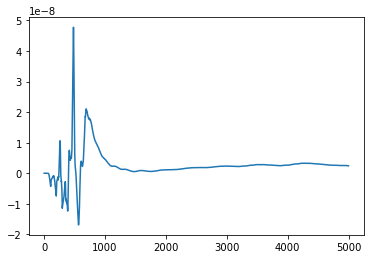

In [249]:
plt.plot(md1[0]-md2[0])
#plt.plot(md2[1])

In [231]:
def params(rho, t):
    return np.array([rho, 1., 10., 0.1, 0.1])
tmp_mat = SecondCoal('a', 1., lambda t: params(1.0, t))
for i, st in enumerate(states):
    for j, st in enumerate(states):
        if tmp_mat[j, i] != 0.0:
            print(states[i].n, states[j].n, tmp_mat[j, i])
#    print("\n")

100,110 011,011,101,101 1.0
101,111 011,011,101,101 10.0
010,100,100 010,100 1.0
011,100,100 011,100 1.0
010,101,101 010,101 10.0
011,101,101 011,101 10.0


In [232]:
(sum(md1[0])+sum(md1[1]))/dt

1.004941161709815

In [264]:
rho_m = 10.0
timeTa = 0.02
method = 'expm'
data_dx = [densityTaTb(method, lambda t: params(rho_m, t), timeTa, (i+offset)/dt)/dt if i != dt else densityTaTb(method, lambda t: params(rho_m, t), timeTa, timeTa) for i in range(numPoint)]

In [265]:
sum(data_dx)

0.9786348067406999

In [252]:
md1[0,1]+md1[1,1]

0.9880736956128787

In [268]:
rho_m = 10.0
method = 'ode'
data_dx = [densityTaTb(method, lambda t: params(rho_m, t), timeTa, (i+offset)/dt)/dt if i != dt else densityTaTb(method, lambda t: params(rho_m, t), timeTa, timeTa) for i in range(numPoint)]

In [269]:
sum(data_dx)

0.9786348678408793

In [266]:
md1[0,-1]+md1[1,-1]

1.1158565208510336e-05

In [278]:
def params(rho, t):
    return np.array([rho, 1., 1., 0.1, 0.1])

Mexp = linalg.expm( dot(M, params(rho_m, 0))*0.02 )
P = dot(Mexp, Pinit)

P = dot(DoubleCoal_2(0.02, lambda t: params(rho_m, t)), P)
sum(P)/dt+sum(data_dx)

0.9852068295080239

In [280]:
dim = 80
dt = 20

rho_dx = 0.001
rho_m = 1.

offset = 0.0

method = 'expm'

def params(rho, t):
    return np.array([rho, 1.0, 1.0, 0.1, 0.1])

data_dx = [[dot(densityTaTb(method, lambda t: params(rho_dx, t), (i+offset)/dt, (j+offset)/dt), np.array([1./dt, 1.])) for j in range(dim)] for i in range(dim) ]
data_dx = np.array(data_dx)
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = row_sums[i]# margdist[i]
    
vals = [i/10. for i in range(1,61)]

TV_eq_size = []
for rho_m in vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)
    data = [[dot(densityTaTb(method, lambda t: params(rho_m, t), (i+offset)/dt, (j+offset)/dt), np.array([1./dt, 1.])) for j in range(dim)] for i in range(dim) ]
    data = np.array(data)
    
    TV_eq_size.append( np.sum(abs(joint_smc-data))/dt*0.5 )

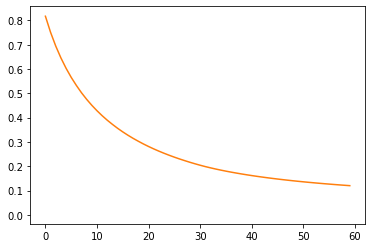

In [281]:
plt.plot(TV_single_pop)
plt.plot(TV_eq_size)

In [284]:
dim = 80
dt = 20

rho_dx = 0.001
rho_m = 1.

offset = 0.0

method = 'expm'

def params(rho, t):
    return np.array([rho, 1.0, 1.0, 0.0, 0.0])

data_dx = [[dot(densityTaTb(method, lambda t: params(rho_dx, t), (i+offset)/dt, (j+offset)/dt), np.array([1./dt, 1.])) for j in range(dim)] for i in range(dim) ]
data_dx = np.array(data_dx)
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = row_sums[i]# margdist[i]
    
vals = [i/10. for i in range(1,61)]

TV_single_pop = []
for rho_m in vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)
    data = [[dot(densityTaTb(method, lambda t: params(rho_m, t), (i+offset)/dt, (j+offset)/dt), np.array([1./dt, 1.])) for j in range(dim)] for i in range(dim) ]
    data = np.array(data)
    
    TV_single_pop.append( np.sum(abs(joint_smc-data))/dt*0.5 )
    
    

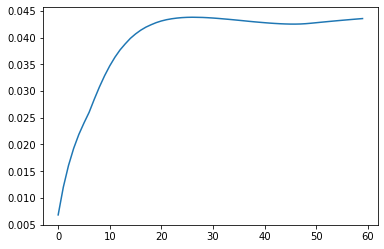

In [285]:
plt.plot(TV_single_pop)

In [286]:
joint_smc.sum(axis=1)

array([1.05      , 0.99877992, 0.95005903, 0.90371528, 0.85963262,
       0.81770066, 0.77781442, 0.73987404, 0.70378456, 0.66945563,
       0.63680135, 0.60573999, 0.57619382, 0.54808891, 0.52135494,
       0.49592502, 0.47173553, 0.44872594, 0.4268387 , 0.40601905,
       0.38621491, 0.36737674, 0.34945743, 0.33241214, 0.31619824,
       0.30077517, 0.28610437, 0.27214913, 0.25887456, 0.24624745,
       0.23423621, 0.22281081, 0.21194268, 0.20160463, 0.19177081,
       0.18241662, 0.17351867, 0.1650547 , 0.15700356, 0.14934509,
       0.14206016, 0.13513054, 0.1285389 , 0.12226875, 0.11630442,
       0.11063099, 0.10523428, 0.10010078, 0.09521765, 0.09057269,
       0.08615428, 0.08195137, 0.07795345, 0.07415052, 0.07053307,
       0.06709205, 0.06381887, 0.06070532, 0.05774363, 0.0549264 ,
       0.05224657, 0.04969744, 0.04727264, 0.0449661 , 0.04277207,
       0.04068504, 0.0386998 , 0.03681139, 0.03501508, 0.03330638,
       0.03168102, 0.03013494, 0.02866426, 0.02726531, 0.02593

In [287]:
sum(row_sums)

21.131870245920602

In [300]:
dim = 400
dt = 50

rho_dx = 0.001
rho_m = 1.

offset = 0.0

method = 'expm'

def params(rho, t):
    return np.array([rho, 1.0, 1.0, 0.0, 0.0])

data_dx = [[dot(densityTaTb(method, lambda t: params(rho_dx, t), (i+offset)/dt, (j+offset)/dt), np.array([1./dt, 1.]))/dt for j in range(dim)] for i in range(dim) ]
data_dx = np.array(data_dx)
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_dist = row_sums/row_sums.sum()
marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = marg_dist[i]# margdist[i]
    
#vals = [i/10. for i in range(1,61)]
rho_vals=[1., 10.]

TV_single_pop = []
for rho_m in rho_vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)
    data = [[dot(densityTaTb(method, lambda t: params(rho_m, t), (i+offset)/dt, (j+offset)/dt), np.array([1./dt, 1.]))/dt for j in range(dim)] for i in range(dim) ]
    data = np.array(data)
    
    TV_single_pop.append( np.sum(abs(joint_smc-data))*0.5 )

TV_single_pop

[0.021482024397105642, 0.004486142850224566]

In [19]:
dim = 800
dt = 100

rho_dx = 0.01
#rho_m = 1.

offset = 0.0

method = 'expm'

scenario = "single_pop"
def single_pop(rho, t):
    return np.array([rho, 1.0, 1.0, 0.0, 0.0])

try:
    os.mkdir("data/"+scenario)
except:
    pass

rho_vals= [0.001, 0.01]+[float(i)/1. for i in range(1, 21)] + [float(i)/2. for i in range(7, 20, 2)] + [float(i)/5. for i in range(1, 15)]
rho_vals=[float(i) for i in range(10, 21)]
rho_vals= [float(i)/1. for i in range(11, 15)]
#rho_vals= [float(i) for i in range(20, 21)] + [float(i)/2. for i in range(11, 21)] + [15., 20.]
rho_vals.sort()
rho_vals=[rho_dx]

for rho_m in rho_vals:
    time1 = time.time()
    fn = filename(scenario, dim, dt, rho_m)
    if os.path.isfile(fn):
        print(fn, "exists")
        continue
    data = [[dot(densityTaTb(method, lambda t: single_pop(rho_m, t), (i+offset)/dt, (j+offset)/dt), np.array([1./dt, 1.]))/dt for j in range(dim)] for i in range(dim) ]
    data = np.array(data)
    np.save(fn, data)
    time2 = time.time()
    print(fn, "created in", time2-time1, "seconds")

#TV_single_pop

data/single_pop/data_800_100_0.01.npy created in 615.6206340789795 seconds


In [6]:
scenario = "single_pop"
dim=800
dt=100
rho_dx = 0.001
fn = filename(scenario, dim, dt, rho_dx)
data_dx = np.load(fn)
data_dx = data_dx/data_dx.sum()
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_dist = row_sums/row_sums.sum()
#marg_dist = row_sums
marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = marg_dist[i]# margdist[i]

rho_vals=[rho_dx]+[float(i)/5. for i in range(0, 51)] + [float(i) for i in range(11, 16)]
#rho_vals= [float(i) for i in range(20, 21)] + [float(i)/2. for i in range(11, 21)] + [15., 20.]
TV_single_pop = []
rhos_single_pop = []
for rho_m in rho_vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)
    
    fn = filename(scenario, dim, dt, rho_m)
    try:
        data = np.load(fn)
        TV_single_pop.append( np.sum(abs(joint_smc-data/data.sum()))*0.5 )
        rhos_single_pop.append(rho_m)
    except:
        pass
#TV_single_pop

0.9996983727951965


0.0021540542986057004

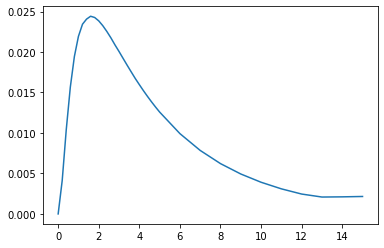

In [7]:
plt.plot(rhos_single_pop, TV_single_pop)

print(data.sum())

TV_single_pop[-1]

In [71]:
dim = 2000
dt = 100

rho_dx = 0.01
#rho_m = 1.

offset = 0.0

method = 'expm'

scenario = "equal_pop"
def equal_pop(rho, t):
    return np.array([rho, 1.0, 1.0, 0.1, 0.1])

try:
    os.mkdir("data/"+scenario)
except:
    pass

#rho_vals= [0.001]+[float(i)/1. for i in range(1, 21)] + [float(i)/2. for i in range(7, 20, 2)] + [float(i)/5. for i in range(1, 15)]
rho_vals= [0.2, 0.4, 0.6, 0.8, 1.2, 2.6, 2.8, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.5, 6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 15., 20.]
rho_vals=[rho_dx, 10., 15.]
rho_vals.sort()
#rho_vals=[rho_dx]
#rho_vals=[0.01]

for rho_m in rho_vals:
    time1 = time.time()
    fn = filename(scenario, dim, dt, rho_m)
    if os.path.isfile(fn):
        print(fn, "exists")
        continue
    data = [[dot(densityTaTb(method, lambda t: equal_pop(rho_m, t), (i+offset)/dt, (j+offset)/dt), np.array([1./dt, 1.]))/dt for j in range(dim)] for i in range(dim) ]
    data = np.array(data)
    np.save(fn, data)
    time2 = time.time()
    print(fn, "created in", time2-time1, "seconds")


data/equal_pop/data_2000_100_0.01.npy exists
data/equal_pop/data_2000_100_10.0.npy exists
data/equal_pop/data_2000_100_15.0.npy created in 4905.570987939835 seconds


In [89]:
scenario = "equal_pop"
dim=1000
dt=50
rho_dx = 0.001
fn = filename(scenario, dim, dt, rho_dx)
data_dx = np.load(fn)
data_dx = data_dx/data_dx.sum()
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_dist = row_sums/row_sums.sum()
#marg_dist = row_sums
marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = marg_dist[i]# margdist[i]

rho_vals= [rho_dx] + [float(i)/5. for i in range(1,25)] + [float(i)/2. for i in range(10,17)]
TV_equal_pop = []
rhos_equal_pop = []
for rho_m in rho_vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)
    
    fn = filename(scenario, dim, dt, rho_m)
    try:
        data = np.load(fn)
        #print(fn)
        TV_equal_pop.append( np.sum(abs(joint_smc-data/data.sum()))*0.5 )
        rhos_equal_pop.append(rho_m)
    except:
        pass

scenario = "equal_pop"
dim=2000
dt=100
rho_dx = 0.01
fn = filename(scenario, dim, dt, rho_dx)
data_dx = np.load(fn)
data_dx = data_dx/data_dx.sum()
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_dist = row_sums/row_sums.sum()
#marg_dist = row_sums
marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = marg_dist[i]# margdist[i]

rho_vals= [10.,15.]
#TV_equal_pop_dim2000 = []
#rhos_equal_pop = []
for rho_m in rho_vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)
    
    fn = filename(scenario, dim, dt, rho_m)
    try:
        data = np.load(fn)
        #print(fn)
        TV_equal_pop.append( np.sum(abs(joint_smc-data/data.sum()))*0.5 )
        rhos_equal_pop.append(rho_m)
    except:
        pass

Text(0, 0.5, 'total variation')

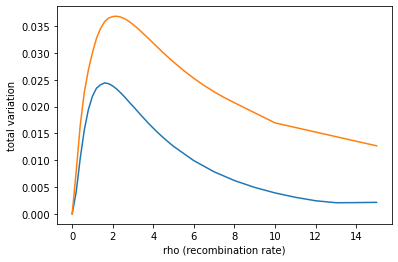

In [90]:
plt.plot(rhos_single_pop, TV_single_pop)
plt.plot(rhos_equal_pop, TV_equal_pop)
plt.xlabel("rho (recombination rate)")
plt.ylabel("total variation")
#plt.ylim([0, 0.1])

In [428]:
joint_smc.sum(axis=0)[:10]

array([0.0204    , 0.01991561, 0.01944306, 0.01898206, 0.01853232,
       0.01809357, 0.01766553, 0.01724794, 0.01684055, 0.01644311])

In [429]:
data.sum(axis=1)[:10]

array([0.0204    , 0.01927003, 0.01840146, 0.01770299, 0.01711668,
       0.01660563, 0.01614622, 0.0157233 , 0.01532704, 0.01495105])

In [461]:
joint_smc.sum()

0.9999999999999383

In [458]:
data.sum()

0.996745522697049

In [443]:
md = MarginalDistr(equal_pop(rho_dx, 0)[1], equal_pop(rho_dx, 0)[2], equal_pop(rho_dx, 0)[3], equal_pop(rho_dx, 0)[4])
md.CalcDist(dim, 1./dt, [1., 0., 0.])[:10]/50

array([0.02      , 0.01883625, 0.01774208, 0.01671331, 0.01574603,
       0.01483653, 0.01398136, 0.01317726, 0.01242115, 0.01171016])

In [439]:
fn = filename(scenario, dim, dt, 10.)
data = np.load(fn)

In [444]:
TV_equal_pop

[0.025186645583921113]

In [468]:
print(rhos_equal_pop)

[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 10.0]


In [478]:
data.sum()

1.0006321853570836

In [31]:
scenario = "single_pop"
dim=800
dt=100
rho_dx = 0.01
fn = filename(scenario, dim, dt, rho_dx)
data_dx = np.load(fn)
data_dx = data_dx/data_dx.sum()
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_dist = row_sums/row_sums.sum()
#marg_dist = row_sums
marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = marg_dist[i]# margdist[i]

rho_vals= [rho_dx] + [float(i)/5. for i in range(25)] + [float(i)/2. for i in range(10,20)]
TV_equal_pop = []
rhos_equal_pop = []
for rho_m in rho_vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)
    
    fn = filename(scenario, dim, dt, rho_m)
    try:
        data = np.load(fn)
        #print(fn)
        TV_equal_pop.append( np.sum(abs(joint_smc-data/data.sum()))*0.5 )
        rhos_equal_pop.append(rho_m)
    except:
        pass
    
scenario = "single_pop"
dim=800
dt=100
rho_dx = 0.001
fn = filename(scenario, dim, dt, rho_dx)
data_dx = np.load(fn)
data_dx = data_dx/data_dx.sum()
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_dist = row_sums/row_sums.sum()
#marg_dist = row_sums
marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = marg_dist[i]# margdist[i]

rho_vals= [rho_dx] + [float(i)/5. for i in range(25)] + [float(i)/2. for i in range(10,20)]
TV_equal_pop1 = []
rhos_equal_pop1 = []
for rho_m in rho_vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)
    
    fn = filename(scenario, dim, dt, rho_m)
    try:
        data = np.load(fn)
        #print(fn)
        TV_equal_pop1.append( np.sum(abs(joint_smc-data/data.sum()))*0.5 )
        rhos_equal_pop1.append(rho_m)
    except:
        pass

Text(0, 0.5, 'total variation')

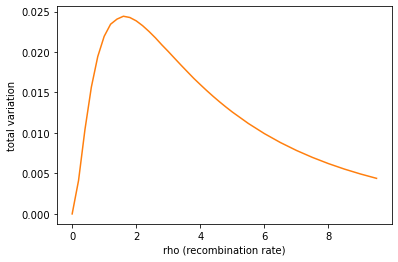

In [87]:
#plt.plot(rhos_single_pop, np.array(TV_single_pop)-np.array(TV_equal_pop1))
plt.plot(rhos_equal_pop, TV_equal_pop)
plt.plot(rhos_equal_pop1, TV_equal_pop1)
plt.xlabel("rho (recombination rate)")
plt.ylabel("total variation")

Text(33.0, 0.5, 'MRCA time at the second locus')

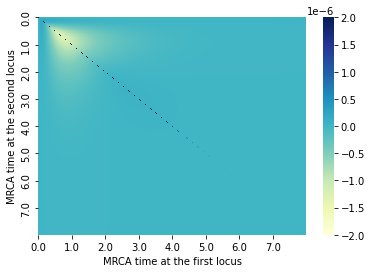

In [11]:
scenario = "single_pop"
dim=800
dt=100
rho_dx = 0.01
fn = filename(scenario, dim, dt, rho_dx)
data_dx = np.load(fn)
data_dx = data_dx/data_dx.sum()
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_dist = row_sums/row_sums.sum()
#marg_dist = row_sums
marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = marg_dist[i]# margdist[i]

rho_vals= [2.0]
TV_equal_pop = []
rhos_equal_pop = []
for rho_m in rho_vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)
    
    fn = filename(scenario, dim, dt, rho_m)
    try:
        data = np.load(fn)
        #print(fn)
        TV_equal_pop.append( np.sum(abs(joint_smc-data/data.sum()))*0.5 )
        rhos_equal_pop.append(rho_m)
    except:
        pass

labels=[i/dt for i in range(dim)]
#labels = [0.0,20.0]
prob_diff = pandas.DataFrame(-joint_smc+data/data.sum(), index = labels,
                  columns = labels)
    
sns.heatmap(prob_diff, cmap="YlGnBu", vmin=-0.000002, vmax=0.000002, xticklabels=100, yticklabels=100)
plt.xlabel("MRCA time at the first locus")
plt.ylabel("MRCA time at the second locus")
#sns.heatmap(-joint_smc+data/data.sum(), cmap="YlGnBu", vmax=0.000001)

Text(33.0, 0.5, 'MRCA time at the second locus')

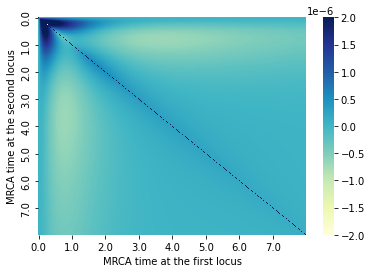

In [10]:
scenario = "equal_pop"
dim=1000
dt=50
rho_dx = 0.001
fn = filename(scenario, dim, dt, rho_dx)
data_dx = np.load(fn)
data_dx = data_dx/data_dx.sum()
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

marg_dist = row_sums/row_sums.sum()
#marg_dist = row_sums
marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = marg_dist[i]# margdist[i]

rho_vals= [2.0]
TV_equal_pop = []
rhos_equal_pop = []
for rho_m in rho_vals:
    joint_smc = np_linalg.matrix_power(trans_matrix_smc, int(rho_m/rho_dx))
    joint_smc = np.matmul(marg_diagonal, joint_smc)
    
    fn = filename(scenario, dim, dt, rho_m)
    try:
        data = np.load(fn)
        #print(fn)
        TV_equal_pop.append( np.sum(abs(joint_smc-data/data.sum()))*0.5 )
        rhos_equal_pop.append(rho_m)
    except:
        pass

labels=[i/dt for i in range(dim)]
#labels = [0.0,20.0]
prob_diff = -joint_smc+data/data.sum()
prob_diff = pandas.DataFrame(prob_diff[:8*dt, :8*dt], index = labels[:8*dt],
                  columns = labels[:8*dt])

#fig, ax = plt.subplots(figsize=(13,10)) 

sns.heatmap(prob_diff, cmap="YlGnBu", vmin=-0.000002, vmax=0.000002, xticklabels=50, yticklabels=50)
plt.xlabel("MRCA time at the first locus")
plt.ylabel("MRCA time at the second locus")
#ax.set_xticklabels([0.0,20.0])
#ax.set_yticklabels([0.0,20.0])